In [1]:
using_colab = True

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    # !mkdir -p images
    # !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/cars.jpg

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-3j2lvcca
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-3j2lvcca
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cache

In [85]:
import sys
!{sys.executable} -m pip install -q mediapipe

In [86]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

In [3]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

using device: cuda


In [5]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)

In [6]:
# !mkdir -p videos/video1/
!mkdir -p frames/deaf/

In [7]:
!find frames/deaf -name "*.zip" | while read file; do \
  unzip "$file" -d "$(dirname "$file")"; \
  rm "$file"; \
  find "$(dirname "$file")" -name "*.zip" | while read inner_zip; do \
    unzip "$inner_zip" -d "$(dirname "$inner_zip")"; \
    rm "$inner_zip"; \
  done; \
done

Archive:  frames/deaf/video1.zip
   creating: frames/deaf/video1/
  inflating: frames/deaf/video1/016.jpg  
  inflating: frames/deaf/video1/002.jpg  
  inflating: frames/deaf/video1/003.jpg  
  inflating: frames/deaf/video1/017.jpg  
  inflating: frames/deaf/video1/029.jpg  
  inflating: frames/deaf/video1/001.jpg  
  inflating: frames/deaf/video1/015.jpg  
  inflating: frames/deaf/video1/014.jpg  
  inflating: frames/deaf/video1/000.jpg  
  inflating: frames/deaf/video1/028.jpg  
  inflating: frames/deaf/video1/.DS_Store  
  inflating: frames/deaf/__MACOSX/video1/._.DS_Store  
  inflating: frames/deaf/video1/004.jpg  
  inflating: frames/deaf/video1/010.jpg  
  inflating: frames/deaf/video1/038.jpg  
  inflating: frames/deaf/video1/039.jpg  
  inflating: frames/deaf/video1/011.jpg  
  inflating: frames/deaf/video1/005.jpg  
  inflating: frames/deaf/video1/013.jpg  
  inflating: frames/deaf/video1/007.jpg  
  inflating: frames/deaf/video1/006.jpg  
  inflating: frames/deaf/video1/012.j

In [8]:
print(os.listdir())

['.config', '.ipynb_checkpoints', 'frames', 'sample_data']


In [46]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./frames/deaf/video9"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
# frame_idx = 29
# plt.figure(figsize=(9, 6))
# plt.title(f"frame {frame_idx}")
# plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [47]:
#image = Image.open('frames/deaf/video5/067.jpg')
image = Image.open('frames/deaf/video9/029.jpg')
image = np.array(image.convert("RGB"))

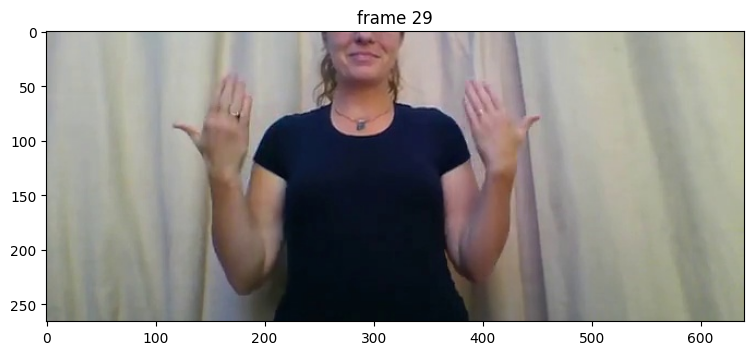

In [51]:
plt.figure(figsize=(9, 6))
frame_idx = 29
plt.title(f"frame {frame_idx}")
plt.imshow(image)
# plt.axis('off')
plt.show()

## Mediapipe

In [87]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

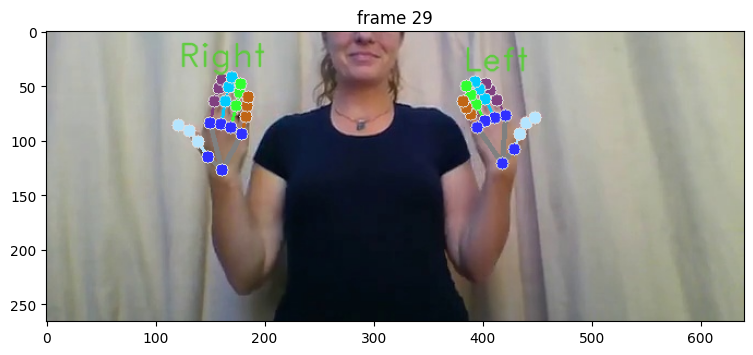

In [101]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
# from google.colab.patches import cv2_imshow

# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
media_image = mp.Image.create_from_file('frames/deaf/video9/029.jpg')

# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(media_image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(media_image.numpy_view(), detection_result)
# cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

plt.figure(figsize=(9, 6))
frame_idx = 29
plt.title(f"frame {frame_idx}")
plt.imshow(annotated_image)
# plt.axis('off')
plt.show()

In [109]:
print(detection_result)
detection_result.handedness

HandLandmarkerResult(handedness=[[Category(index=1, score=0.9908429980278015, display_name='Left', category_name='Left')], [Category(index=0, score=0.9845600724220276, display_name='Right', category_name='Right')]], hand_landmarks=[[NormalizedLandmark(x=0.6538984775543213, y=0.45717495679855347, z=1.3481532334935764e-08, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.6714775562286377, y=0.4097335636615753, z=0.0009130091057159007, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.6795551776885986, y=0.35470375418663025, z=-0.00039217586163431406, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.6881530284881592, y=0.3159070312976837, z=-0.0026670503430068493, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.7003169059753418, y=0.2982252538204193, z=-0.0054321144707500935, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.6579862833023071, y=0.29284292459487915, z=0.0006874405080452561, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.6454254984855652, y=0.

[[Category(index=1, score=0.9908429980278015, display_name='Left', category_name='Left')],
 [Category(index=0, score=0.9845600724220276, display_name='Right', category_name='Right')]]

In [119]:
# detection_result.hand_landmarks

### Plot region bounding

In [125]:
height, width, _ = image.shape
# Convert relative coords to pixel coords
pixel_points = np.array([
    [lm.x * width,lm.y * height]  # if coords are centered around 0
    for sublist in detection_result.hand_landmarks
    for lm in sublist
])

In [126]:
# Get bounding box
x_min, y_min = pixel_points.min(axis=0)
x_max, y_max = pixel_points.max(axis=0)

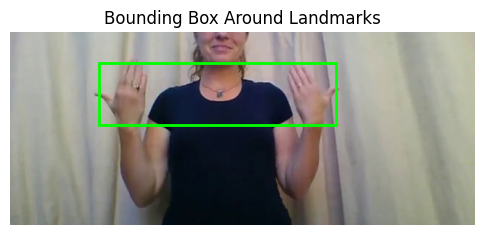

In [130]:
import matplotlib.patches as patches

# Get bounding box limits
x_min, y_min = pixel_points.min(axis=0)
x_max, y_max = pixel_points.max(axis=0)
box_width = x_max - x_min
box_height = y_max - y_min

# Plot image and box
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image)
rect = patches.Rectangle((x_min, y_min), box_width, box_height,
                         linewidth=2, edgecolor='lime', facecolor='none')
ax.add_patch(rect)
ax.set_title("Bounding Box Around Landmarks")
ax.axis('off')
plt.show()

## Automatic mask generation

In [52]:
from sam2.build_sam import build_sam2
from sam2.build_sam import build_sam2_video_predictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)
predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [53]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 122/122 [00:03<00:00, 34.82it/s]


In [54]:
predictor.reset_state(inference_state)

In [32]:
# masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [35]:
# plt.figure(figsize=(20, 20))
# plt.imshow(image)
# show_anns(masks)
# plt.axis('off')
# plt.show()

In [36]:
# print(masks[0].keys())

In [55]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=8,
    points_per_batch=32,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

In [56]:
masks2 = mask_generator_2.generate(image)

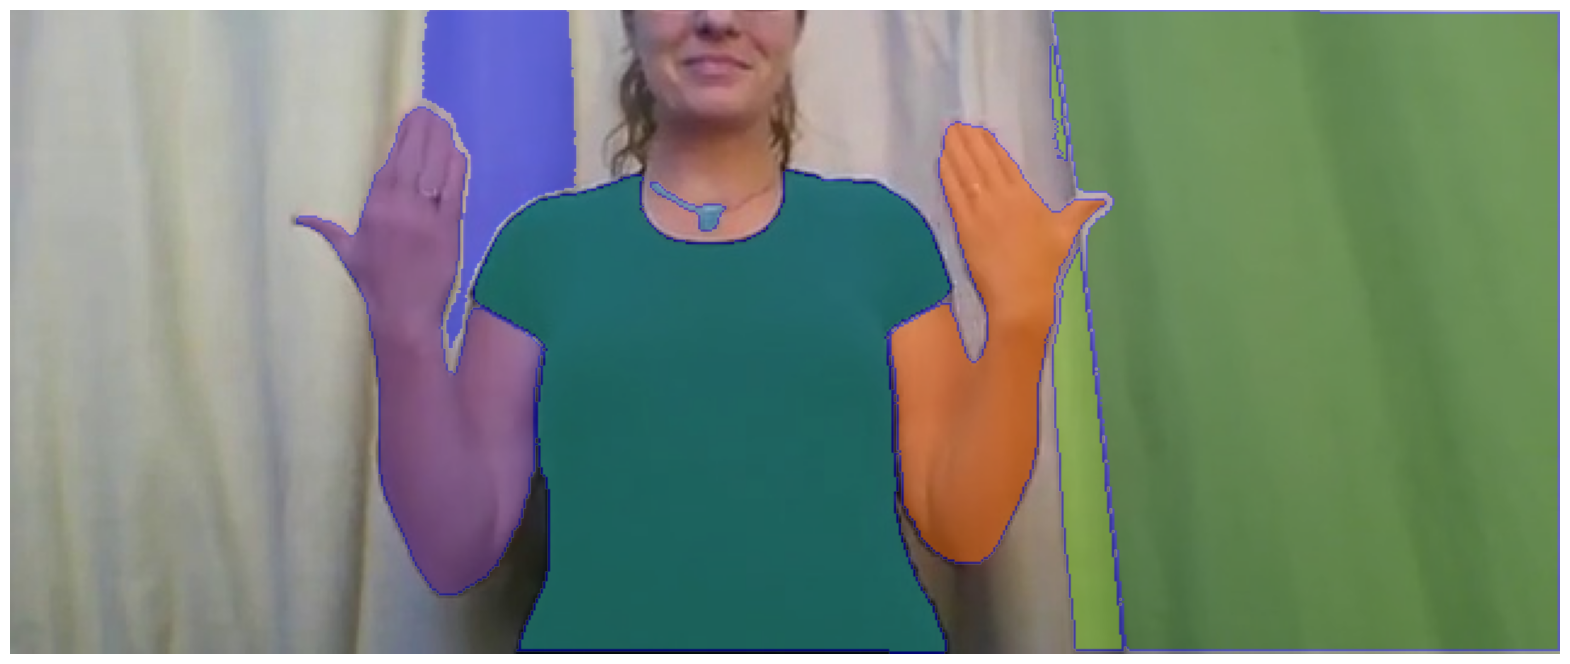

In [57]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks2)
# plt.axis('off')
plt.show()

## Mask out (calculate iou)

In [ ]:
# 1. there is one default image (image)
# 2. there is bbox for masks
# 3. there is bounding box values (patches.Rectangle)
# 4. Want to find the mask that is closest to the bounding box

In [133]:
print(masks2[3]['bbox'])

[118.0, 40.0, 101.0, 201.0]


In [137]:
print(rect)

Rectangle(xy=(121.614, 42.8733), width=326.589, height=84.3398, angle=0)


In [144]:
def draw_box_with_label(image, box, label=None, color='lime'):
    x, y, w, h = box

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(image)

    # Draw the box
    rect = patches.Rectangle((x, y), w, h, linewidth=2,
                             edgecolor=color, facecolor='none')
    ax.add_patch(rect)

    # Draw the label text (e.g. coords or IoU)
    if label:
        ax.text(x, y - 5, label, fontsize=12, color=color,
                bbox=dict(facecolor='black', alpha=0.5, pad=2))

    ax.axis('off')
    plt.show()

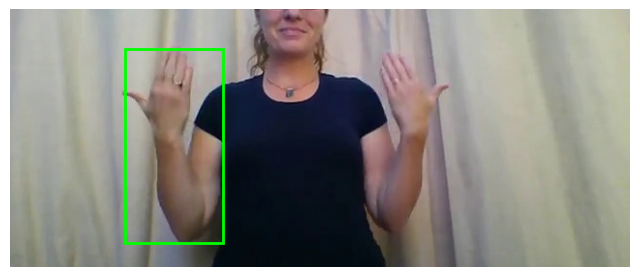

In [145]:
draw_box_with_label(image, masks2[3]['bbox'])

In [146]:
def compute_bbox_iou(mask_box, hand_box):
    # Extract coordinates
    x1, y1 = mask_box[0], mask_box[1]
    w1, h1 = mask_box[2], mask_box[3]
    x1_max = x1 + w1
    y1_max = y1 + h1

    x2, y2 = hand_box.get_xy()
    w2, h2 = hand_box.get_width(), hand_box.get_height()
    x2_max, y2_max = x2 + w2, y2 + h2

    # Compute intersection box
    inter_x_min = max(x1, x2)
    inter_y_min = max(y1, y2)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    inter_w = max(0, inter_x_max - inter_x_min)
    inter_h = max(0, inter_y_max - inter_y_min)
    inter_area = inter_w * inter_h

    # Compute areas
    area1 = w1 * h1
    area2 = w2 * h2
    union_area = area1 + area2 - inter_area

    if union_area == 0:
        return 0.0

    return inter_area / union_area

In [147]:
iou = compute_bbox_iou(masks2[3]['bbox'], rect)
print(f"IoU between boxes: {iou:.4f}")

IoU between boxes: 0.2072


In [154]:
best_mask = {}

for idx, mask_data in enumerate(masks2):
    mask = mask_data['segmentation']  # Binary mask
    bbox = mask_data.get('bbox', [])  # Bounding box
    iou = compute_bbox_iou(bbox, rect)
    best_mask[idx] = iou

print(best_mask.keys())
print(best_mask.values())

dict_keys([0, 1, 2, 3, 4, 5, 6])
dict_values([np.float64(0.17146651678677322), np.float64(0.018910128983451617), np.float64(0.2205034522603413), np.float64(0.20724486003546855), np.float64(0.048453810008697744), np.float64(0.1879156405639042), np.float64(0.022509076471272545)])


In [156]:
# Sort dictionary items by value (descending)
sorted_items = sorted(best_mask.items(), key=lambda item: item[1], reverse=True)

# Get top 2 keys
first_max_key = sorted_items[0][0]
second_max_key = sorted_items[1][0]

print(f"First max key: {first_max_key}, value: {best_mask[first_max_key]}")
print(f"Second max key: {second_max_key}, value: {best_mask[second_max_key]}")

First max key: 2, value: 0.2205034522603413
Second max key: 3, value: 0.20724486003546855


## Visualize Mask

In [59]:
import cv2
import json

# Create folders for masks and metadata
os.makedirs("masks2", exist_ok=True)
os.makedirs("metadata2", exist_ok=True)

# Save each mask and corresponding metadata
for idx, mask_data in enumerate(masks2):
    mask = mask_data['segmentation']  # Binary mask
    bbox = mask_data.get('bbox', [])  # Bounding box

    # Save mask as an image
    cv2.imwrite(f"masks2/mask_{idx}.png", (mask * 255).astype(np.uint8))

    # Save metadata as a JSON file
    metadata = {
        'mask_id': idx,
        'bbox': bbox
    }
    with open(f"metadata2/mask_{idx}.json", 'w') as f:
        json.dump(metadata, f, indent=4)

In [73]:
prompts = {}

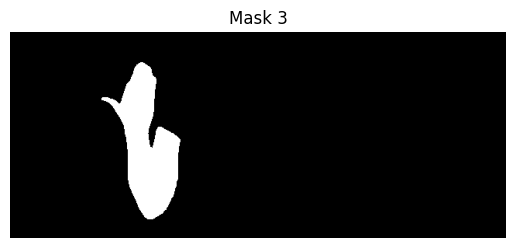

In [74]:
idx = 3
plt.imshow(masks2[idx]['segmentation'], cmap='gray')
plt.title(f"Mask {idx}")
plt.axis('off')
plt.show()

In [75]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

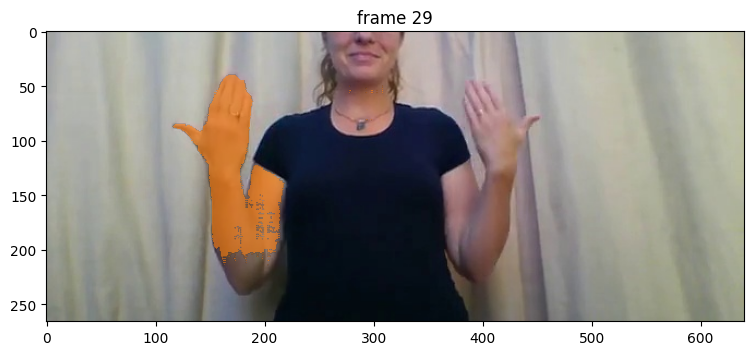

In [79]:
# add the first object
ann_frame_idx = 29  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

idx = 3
box = masks2[idx].get('bbox', [])
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
prompts[ann_obj_id] = box, # labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    box=box,
    # labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
# show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    # show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

### Propagate the prompts to get masklets across the video

In [80]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

propagate in video: 100%|██████████| 93/93 [01:38<00:00,  1.06s/it]


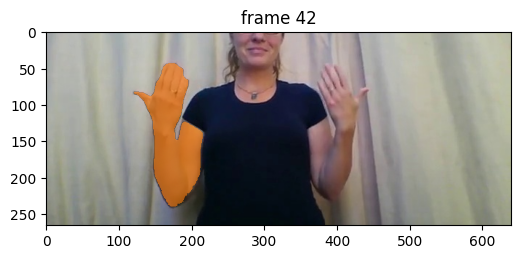

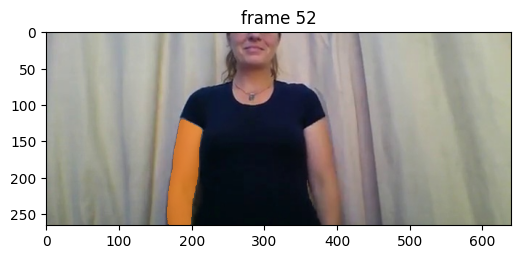

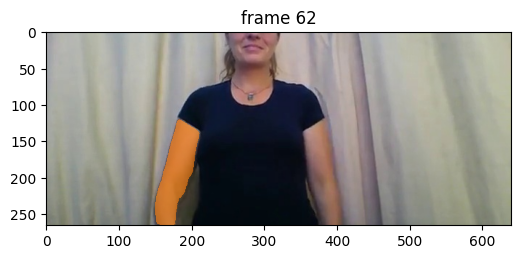

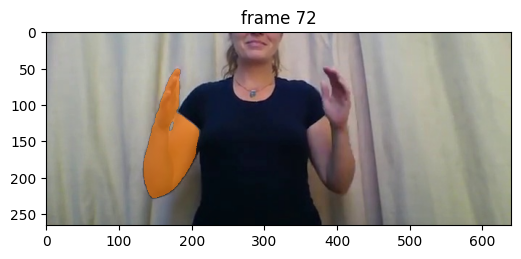

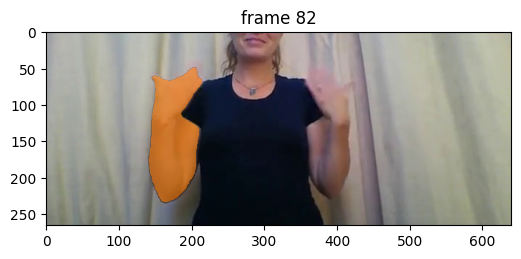

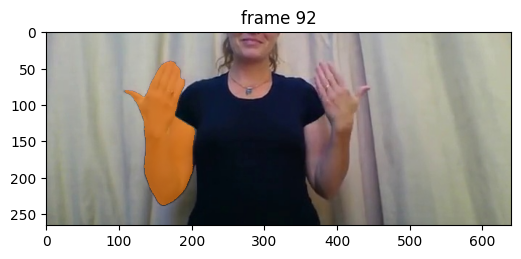

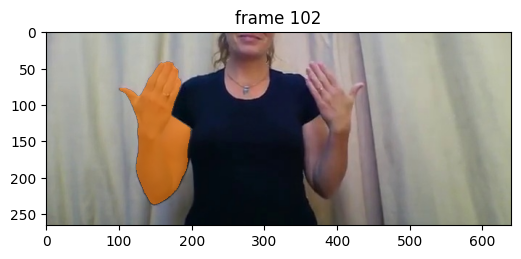

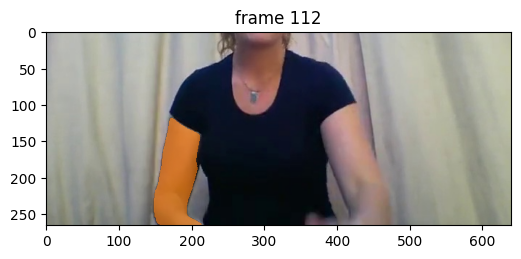

In [81]:
vis_frame_stride = 10
plt.close("all")
for out_frame_idx in range(42, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)